# Variability analysis

An important step in computational modelling is the analysis of the sensitivity of model results to parameter changes. Metabolic Control Analysis (MCA) provides tools for analyzing the effects of such changes on the steady state of the model.

In [2]:
from __future__ import print_function, division
%matplotlib inline

import roadrunner
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

We are interested in the effects of parameters for a given simulation scenario. The analysed scenario is simple simulation to steady state.

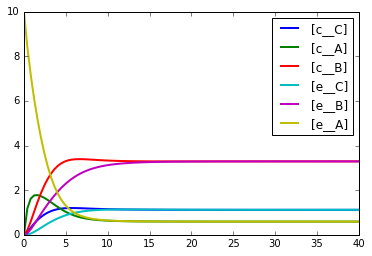

c__C = 1.11845145723
c__A = 0.592003504934
c__B = 3.28951210035
e__C = 1.11846859032
e__B = 3.28944074714
e__A = 0.592123600021


In [4]:
# from multiscale.examples.testdata import demo_filepath
demo_sbml = "../models/demo/Koenig_demo_v09.xml"

# equidistant timecourse
roadrunner.Config.setValue(roadrunner.Config.LOADSBMLOPTIONS_CONSERVED_MOIETIES, True)
r = roadrunner.RoadRunner(demo_sbml)
s = r.simulate(0, 40, 100, plot=True)  

for sid, value in zip(r.model.getFloatingSpeciesIds(), r.model.getFloatingSpeciesConcentrations()):
    print('{} = {}'.format(sid, value))

In [7]:
# Steady States
# Performs a steady state calculation (evolves the system to a steady
#        state), then calculates and returns the set of values specified by
#        the steady state selections.
# [issue #258 https://github.com/sys-bio/roadrunner/issues/258]
print(r.steadyStateSelections)
print(r.getSteadyStateValues())

['[c__C]', '[c__A]', '[c__B]', '[e__C]', '[e__B]', '[e__A]']
[ 1.11842105  0.59210526  3.28947368  1.11842105  3.28947368  0.59210526]


In [8]:
# The steady state fluxes are
print(r.model.getReactionIds())
print(r.getReactionRates())

['bA', 'bB', 'bC', 'v1', 'v2', 'v3', 'v4']
[ -1.39094894e-17  -5.52057367e-20   4.45205012e-20   2.63157895e-07
   2.96052632e-07   5.59210526e-07  -2.63157895e-07]


## Metabolic Control Analysis (MCA)

Metabolic control analysis (MCA) is a mathematical framework for describing metabolic, signaling, and genetic pathways. MCA quantifies how variables, such as fluxes and species concentrations, depend on network parameters. In particular it is able to describe how network dependent properties, called control coefficients, depend on local properties called elasticities [http://en.wikipedia.org/wiki/Metabolic_control_analysis].

For the available functions in roadrunner see
https://sys-bio.github.io/roadrunner/python_docs/metabolic.html

### Control Coefficients

A control coefficient measures the relative steady state change in a system variable, e.g. pathway flux (J) or metabolite concentration (S), in response to a relative change in a parameter, e.g. enzyme activity or the steady-state rate ( v_i ) of step i. The two main control coefficients are the flux and concentration control coefficients. Flux control coefficients are defined by:

$$C^J_{v_i} = \left( \frac{dJ}{dp} \frac{p}{J} \right) \bigg/ \left( \frac{\partial v_i}{\partial p}\frac{p}{v_i} \right) = \frac{d\ln J}{d\ln v_i}$$

In [9]:
# Scaled control coefficient with respect to a global parameter.
r.getCC('bA', 'Vmax_bA')

-0.7417840375586783

In [11]:
# The n by n matrix of scaled flux control coefficients 
# where n is the number of reactions.

# [issue #251 https://github.com/sys-bio/roadrunner/issues/251]
print('** Scaled Flux Control Coefficients **')
r.getScaledFluxControlCoefficientMatrix()
C_J = DataFrame(rr.getScaledFluxControlCoefficientMatrix(), \
                index=r.model.getReactionIds(), \
                columns=r.model.getReactionIds())
print(C_J)

** Scaled Flux Control Coefficients **


RuntimeError: Unexpected error from getScaledFluxControlCoefficientMatrix(): Dividing with zero

and concentration control coefficients by:

$$C^S_{v_i} = \left( \frac{dS}{dp} \frac{p}{S} \right) \bigg/ \left( \frac{\partial v_i}{\partial p} \frac{p}{v_i} \right) = \frac{d\ln S}{d\ln v_i}$$

In [12]:
# The m by n matrix of scaled concentration control coefficients where m is the number
# of floating species and n the number of reactions.
print('** Scaled Concentration Control Coefficients **')
C_S = DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), \
                index=r.model.getFloatingSpeciesIds(), \
                columns=r.model.getReactionIds())
print(C_S)

** Scaled Concentration Control Coefficients **
                bA  bB  bC        v1        v2        v3        v4
c__C  6.661339e-17  -0  -0 -0.030960  0.188080 -0.355263  0.198142
c__A  6.661339e-17  -0  -0 -0.292398 -0.223684  0.422515  0.093567
c__B  6.661339e-17  -0  -0  0.063158 -0.023684  0.044737 -0.084211
e__C  6.661339e-17  -0   0 -0.030960  0.188080 -0.355263  0.198142
e__B  6.661339e-17   0  -0  0.063158 -0.023684  0.044737 -0.084211
e__A -1.058413e-15  -0  -0 -0.292398 -0.223684  0.422515  0.093567


### Summation Theorems

The flux control summation theorem was discovered independently by the Kacser/Burns group and the Heinrich/Rapoport group in the early 1970s and late 1960s. The flux control summation theorem implies that metabolic fluxes are systemic properties and that their control is shared by all reactions in the system. When a single reaction changes its control of the flux this is compensated by changes in the control of the same flux by all other reactions.

$$\sum_i C^J_{v_i} = 1$$

$$\sum_i C^S_{v_i} = 0$$

In [13]:
# Flux control coefficients have to sum to 1
print(np.sum(C_J, axis=1))
abs(np.sum(C_J, axis=1)-1) < 1E-6

NameError: name 'C_J' is not defined

In [14]:
# Concentration control coefficients have to sum to 0
print(np.sum(C_S, axis=1))
np.sum(C_S, axis=1) < 1E-6

c__C   -5.551115e-17
c__A    1.665335e-16
c__B    8.326673e-17
e__C    0.000000e+00
e__B    8.326673e-17
e__A   -9.298118e-16
dtype: float64


c__C    True
c__A    True
c__B    True
e__C    True
e__B    True
e__A    True
dtype: bool

### Elasticity coefficients
Retrieve a single elasticity coefficient with respect to a global parameter.

        For example::

          x = rr.getEE ('J1', 'Vmax')

In [15]:
print(r.model.getGlobalParameterIds())
print(r.getEE('v1', 'Vmax_v1'))
print(r.getEE('v1', 'Keq_v1'))

['Km_C', 'scale_f', 'Vmax_bB', 'Vmax_bC', 'Vmax_bA', 'Vmax_v2', 'Vmax_v3', 'Vmax_v1', 'Km_A', 'Vmax_v4', 'Km_B', 'Keq_v4', 'Keq_v1', 'cm_0_c4e7f1e0_bb65_11e5_9bda_bcaec50efb75']
1.0
1.24996835523
